In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Locations of .csv files
Amazon_Subsidies = 'CSV/Amazon_Subsidies.csv'
State_Subsidies = 'CSV/Total_Subsidies_By_State.csv'

In [3]:
# Read .csv files
df_amazon = pd.read_csv(Amazon_Subsidies, header=0)
df_state_subsidies = pd.read_csv(State_Subsidies, header=0)

In [4]:
# Let's see which columns we want to keep
df_amazon.columns

Index(['Company', 'Parent Company', 'Location', 'City', 'County', 'Address',
       'Zip', 'Project Description', 'NAICS Industry Code', 'Year',
       'Subsidy Value', 'Megadeal Contribution',
       'Subsidy Value Adjusted For Megadeal', 'Program Name',
       'Awarding Agency', 'Type of Subsidy',
       'Number of Jobs or Training Slots', 'Wage Data', 'Wage Data Type',
       'Investment Data', 'Source of Data', 'Notes', 'Subsidy Source',
       'CFDA Program Number', 'Loan Value',
       'State in Which Facility Is Located', 'HQ State of Parent',
       'HQ Country of Parent', 'Ownership Structure',
       'Major Industry of Parent', 'Specific Industry of Parent'],
      dtype='object')

In [5]:
df_amazon = df_amazon[['Parent Company','Location','City','Year','Subsidy Value']]
df_amazon.sort_values(by='Location').head()

,Parent Company,Location,City,Year,Subsidy Value
165,Amazon.com,Alabama,Bessemer,2018.0,"$54,600,000"
21,Amazon.com,Arizona,Phoenix,2008.0,"$739,671"
15,Amazon.com,Arizona,NaN,2008.0,undisclosed
14,Amazon.com,Arizona,NaN,2008.0,undisclosed
94,Amazon.com,California,NaN,2017.0,"$1,091,000"


In [6]:
df_state_subsidies.columns

Index(['Rank', 'State', 'State Name', 'Subsidy Total Dollars',
       'Number of Awards'],
      dtype='object')

In [7]:
df_state_subsidies.head()
# Removing the rank column
df_state_subsidies = df_state_subsidies.iloc[:,1:]

In [8]:
df_state_subsidies.head()

,State,State Name,Subsidy Total Dollars,Number of Awards
0,NY,New York,"$33,969,437,664","127,152"
1,LA,Louisiana,"$25,219,037,615","9,286"
2,MI,Michigan,"$15,468,972,322","17,680"
3,WA,Washington,"$13,926,001,594","23,518"
4,NJ,New Jersey,"$10,727,322,838","14,784"


In [9]:
# Let's merge these two
df = pd.merge(df_amazon, df_state_subsidies, left_on='Location', right_on='State Name')

In [10]:
# Take just the columns we need
df = df[['State','State Name','Subsidy Total Dollars','City','Year','Subsidy Value','Number of Awards']]

In [11]:
# Cleaning up the merged dataframe
df = df[df['Subsidy Value'] != 'undisclosed']

for rows in ['Subsidy Total Dollars','Subsidy Value']:
    df[rows] = df[rows].str.replace('$','')
    df[rows] = df[rows].str.replace(',','')
    df[rows] = pd.to_numeric(df[rows])

In [12]:
df.reset_index(drop=True, inplace=True)

## Exploratory Analysis

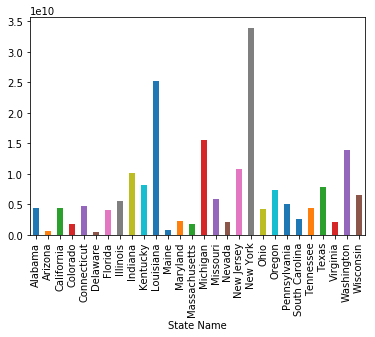

In [13]:
# What is the mean subsidy value per State to Amazon
df.groupby('State Name')['Subsidy Value'].sum().plot.bar()
# What is the State with the most subsidies overall?
df.groupby('State Name')['Subsidy Total Dollars'].mean().plot.bar()

plt.show()

In [14]:
# Now that we have an overview let's set up a colormap
import seaborn as sns

# Create the color map based on the unique State names using seaborn presets
color_labels = df['State Name'].unique()
rgb_values = sns.color_palette("Set2", len(df['State Name'].unique()))
color_map = dict(zip(color_labels, rgb_values))

In [15]:
# Now let's test it out with just our 20 States
top_20 = {'Atlanta': 'GA', 'Austin' :'TX', 'Boston': 'MA', 'Chicago': 'IL', 'Columbus': 'OH', 'Dallas': 'TX', 'Denver': 'CO', 'Indianapolis': 'IN', 'Los Angeles': 'CA', 'Miami': 'FL', 'Montgomery County': 'MD', 'Nashville': 'TN', 'Newark': 'NJ', 'New York': 'NY', 'Northern Virginia': 'VA', 'Philadelphia': 'PA', 'Pittsburgh': 'PA', 'Raleigh': 'NC', 'Toronto': 'Ontario', 'Washington': 'D.C.'}
states = list(top_20.values())
len(states)

20

In [16]:
# narrowing the df to contain only our 20 states
df = df[df['State'].str.contains(('|').join(states))]

In [17]:
# Diving by 10^6 to simplify the large dollar amounts
df['Subsidy Total Dollars'] = df['Subsidy Total Dollars']/1000000
df['Subsidy Value'] = df['Subsidy Value']/1000000

In [18]:
df.head()

,State,State Name,Subsidy Total Dollars,City,Year,Subsidy Value,Number of Awards
34,NJ,New Jersey,10727.322838,Newark,2015.0,39.375,"14,784"
35,PA,Pennsylvania,5002.901627,NaN,NaN,1.250,"13,465"
36,PA,Pennsylvania,5002.901627,NaN,2016.0,5.000,"13,465"
37,PA,Pennsylvania,5002.901627,NaN,2016.0,15.000,"13,465"
38,PA,Pennsylvania,5002.901627,NaN,2016.0,2.250,"13,465"


In [19]:
df.rename(columns={'Subsidy Total Dollars': 'Subsidy Total Dollars - All Corp (in millions)', 'Subsidy Value': 'Subsidy Value - Amazon (in millions)'}, inplace=True)


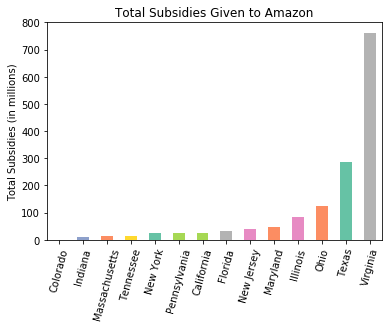

In [20]:
# Who has already given Amazon the most money?
to_plot = df.groupby('State Name')['Subsidy Value - Amazon (in millions)'].sum().sort_values()
to_plot.plot.bar(title='Total Subsidies Given to Amazon', color=to_plot.index.map(color_map), rot=75)

plt.xlabel(None)
plt.ylabel('Total Subsidies (in millions)')
plt.savefig('Charts/Total_Subsidy_Given_To_Amazon', bbox_inches='tight', dpi=300)
plt.show()

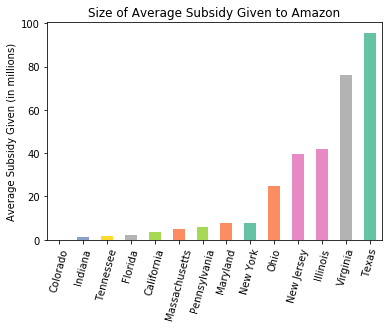

In [22]:
# Who has given Amazon the largest mean subsidies already?
to_plot = df.groupby('State Name')['Subsidy Value - Amazon (in millions)'].mean().sort_values()
to_plot.plot.bar(title = 'Size of Average Subsidy Given to Amazon', color=to_plot.index.map(color_map), rot=75)


plt.xlabel(None)
plt.ylabel('Average Subsidy Given (in millions)')
plt.savefig('Charts/Average_Subsidy_Given_To_Amazon', bbox_inches='tight', dpi=300)
plt.show()

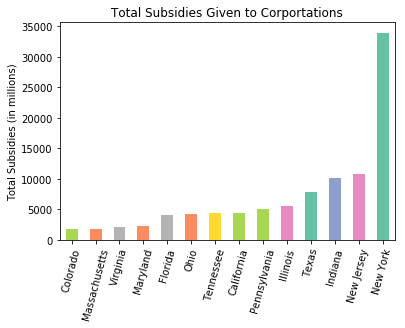

In [23]:
# Who's most likely to give us a big subsidy?
# Subsidy Total Dollars = NON Amazon - All companies!
# I use mean here because this is a static value per state occurence in the df so the mean equals the exact value
to_plot = df.groupby('State Name')['Subsidy Total Dollars - All Corp (in millions)'].mean().sort_values()
to_plot.plot.bar(title='Total Subsidies Given to Corportations', color=to_plot.index.map(color_map), rot=75)

plt.xlabel(None)
plt.ylabel('Total Subsidies (in millions)')
plt.savefig('Charts/Total_Subsidies_Given_All_Companies', bbox_inches='tight', dpi=300)
plt.show()
# Top is 35 billion

In [ ]:
df